In [5]:
#load libraries
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os as os

In [129]:
#Loop to read in data and make dataframes

march_path="./data/march_april/"
april_path="./data/april_may/"

march_file_list=[file for file in os.listdir(march_path) if file.endswith('.csv')]

april_file_list=[file for file in os.listdir(april_path) if file.endswith('.csv')]

#function to check if march and april lists are identical
def compare_lists(list1,list2):
    if len(list1) != len(list2):
        return False
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            return False
    return True


#loop to read files
dataframes_dict={}
if compare_lists(march_file_list,april_file_list)==True:
    for i in range(len(march_file_list)):
        dataframes_dict[march_file_list[i][:len(march_file_list[i])-4]]=pd.concat([pd.read_csv(march_path+march_file_list[i]),pd.read_csv(april_path+april_file_list[i])])
else: 
    print(f"Check to see if the same number of files are in each directory and if the names are the same.  compare= {compare_lists(march_file_list,april_file_list)}")                                                                     


In [168]:
dataframes_dict['minuteStepsNarrow_merged']

,Id,ActivityMinute,Steps
0,1503960366,3/12/2016 12:00:00 AM,0
1,1503960366,3/12/2016 12:01:00 AM,0
2,1503960366,3/12/2016 12:02:00 AM,0
3,1503960366,3/12/2016 12:03:00 AM,0
4,1503960366,3/12/2016 12:04:00 AM,0
...,...,...,...
1325575,8877689391,5/12/2016 1:55:00 PM,0
1325576,8877689391,5/12/2016 1:56:00 PM,0
1325577,8877689391,5/12/2016 1:57:00 PM,0
1325578,8877689391,5/12/2016 1:58:00 PM,0


In [163]:
dataframes_dict['minuteStepsNarrow_merged'].info()
dataframes_dict.keys()


<class 'pandas.core.frame.DataFrame'>
Index: 2770620 entries, 0 to 1325579
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Id              int64 
 1   ActivityMinute  object
 2   Steps           int64 
dtypes: int64(2), object(1)
memory usage: 84.6+ MB


dict_keys(['dailyActivity_merged', 'heartrate_seconds_merged', 'hourlyCalories_merged', 'hourlyIntensities_merged', 'hourlySteps_merged', 'minuteCaloriesNarrow_merged', 'minuteIntensitiesNarrow_merged', 'minuteMETsNarrow_merged', 'minuteSleep_merged', 'minuteStepsNarrow_merged'])

In [131]:
#get intensity data
#load the dataframe
df_intensity_minute=dataframes_dict['minuteIntensitiesNarrow_merged']

#convert ActivityMinute to date time and extract the date
df_intensity_minute["ActivityMinute"]=pd.to_datetime(df_intensity_minute["ActivityMinute"],format='%m/%d/%Y %I:%M:%S %p')
df_intensity_minute["date"]=df_intensity_minute["ActivityMinute"].dt.strftime('%Y-%m-%d')

#Remove rows where Intensity is 0 (0 is resting)
df_intensity_day=df_intensity_minute[df_intensity_minute["Intensity"] !=0]

#drop the ActivityMinute column and group by Id and date
df_intensity_day=df_intensity_day.drop(columns=["ActivityMinute"])
df_intensity_day=df_intensity_day.groupby(by=["Id","date"]).size().reset_index(name="intensity_minutes")

df_intensity_day.info()
display(df_intensity_day.head())






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 1688 non-null   int64 
 1   date               1688 non-null   object
 2   intensity_minutes  1688 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 39.7+ KB


,Id,date,intensity_minutes
0,1503960366,2016-03-12,384
1,1503960366,2016-03-13,334
2,1503960366,2016-03-14,298
3,1503960366,2016-03-15,403
4,1503960366,2016-03-16,318


In [142]:
#get sleep data
#load the dataframe
df_sleep_minute=dataframes_dict['minuteSleep_merged']

#convert date to date time, extract the date, rename date2
#df_sleep_minute["date"]=pd.to_datetime(df_sleep_minute["date"],format='%m/%d/%Y %I:%M:%S %p')
#df_sleep_minute["date2"]=df_sleep_minute["date"].dt.strftime('%Y-%m-%d')

#drop the date and logId columns, reanme date2, group by Id and date
#df_sleep_day=df_sleep_minute.drop(columns=["date","logId"])
#df_sleep_day=df_sleep_day.rename(columns={"date2":"date"})
#df_sleep_day=df_sleep_day.groupby(by=["Id","date"]).count().reset_index()


#df_sleep_day.info()
#display(df_sleep_day.head())
#print(df_sleep_day["value"].max())

#row_1149=df_sleep_day[df_sleep_day["value"]==1149]
#display(row_1149)

In [133]:
#merge intensity and sleep data
df_intensity_sleep_day=pd.merge(df_intensity_day,df_sleep_day,
                                how="inner",
                                on=["Id","date"]
                                )

df_intensity_sleep_day.info()
display(df_intensity_sleep_day.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385436 entries, 0 to 385435
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 385436 non-null  int64 
 1   date               385436 non-null  object
 2   intensity_minutes  385436 non-null  int64 
 3   value              385436 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 11.8+ MB


,Id,date,intensity_minutes,value
0,1503960366,2016-03-13,334,1
1,1503960366,2016-03-13,334,1
2,1503960366,2016-03-13,334,1
3,1503960366,2016-03-13,334,1
4,1503960366,2016-03-13,334,1


,intensity_minutes,sleep_minutes
intensity_minutes,1.000000,-0.048589
sleep_minutes,-0.048589,1.000000


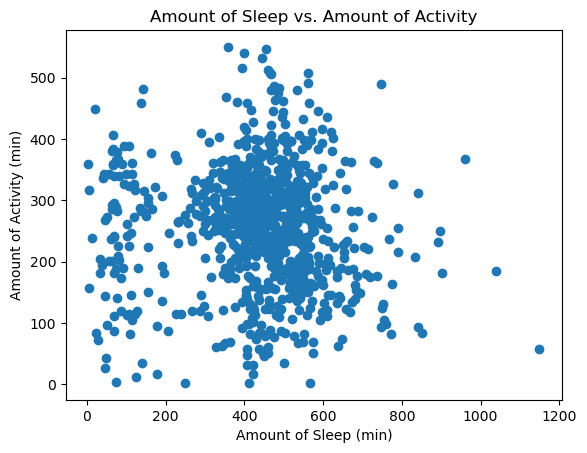

In [103]:
#find correlation coefficients
display(df_intensity_sleep_day[["intensity_minutes","sleep_minutes"]].corr())

#plot
fig1, ax1=plt.subplots()
ax1.scatter(x=df_intensity_sleep_day["sleep_minutes"], y=df_intensity_sleep_day["intensity_minutes"])
ax1.set_xlabel("Amount of Sleep (min)")
ax1.set_ylabel("Amount of Activity (min)")
ax1.set_title("Amount of Sleep vs. Amount of Activity")
plt.show()

In [159]:
#debug=df_sleep_day.copy()
#debug=debug[(debug["Id"]==1927972279) & (debug["date"]=="2016-04-12")]
#debug=debug[debug["date"]=="2016-04-12"]


#debug=df_sleep_minute
#debug=debug[(debug["Id"]==1927972279) & (debug["date2"]=="2016-04-12")]

#debug

debug=pd.read_csv("./data/april_may/minuteSleep_merged.csv")
debug=debug[(debug["Id"]==1927972279)]  #& (debug["date2"]=="2016-04-12")]
debug


,Id,date,value,logId
13847,1927972279,4/11/2016 9:56:00 PM,1,11372414035
13848,1927972279,4/11/2016 9:57:00 PM,1,11372414035
13849,1927972279,4/11/2016 9:58:00 PM,1,11372414035
13850,1927972279,4/11/2016 9:59:00 PM,1,11372414035
13851,1927972279,4/11/2016 10:00:00 PM,1,11372414035
...,...,...,...,...
16031,1927972279,4/28/2016 2:35:00 PM,1,11507403943
16032,1927972279,4/28/2016 2:36:00 PM,1,11507403943
16033,1927972279,4/28/2016 2:37:00 PM,2,11507403943
16034,1927972279,4/28/2016 2:38:00 PM,1,11507403943
